In [11]:
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
import random

In [12]:
import os


In [13]:
pwd

'C:\\Users\\akash'

In [14]:
data_path = './data.txt'
G_social = nx.read_edgelist(data_path)
data_path1='./data2.txt'
G_social1 = nx.read_edgelist(data_path1)

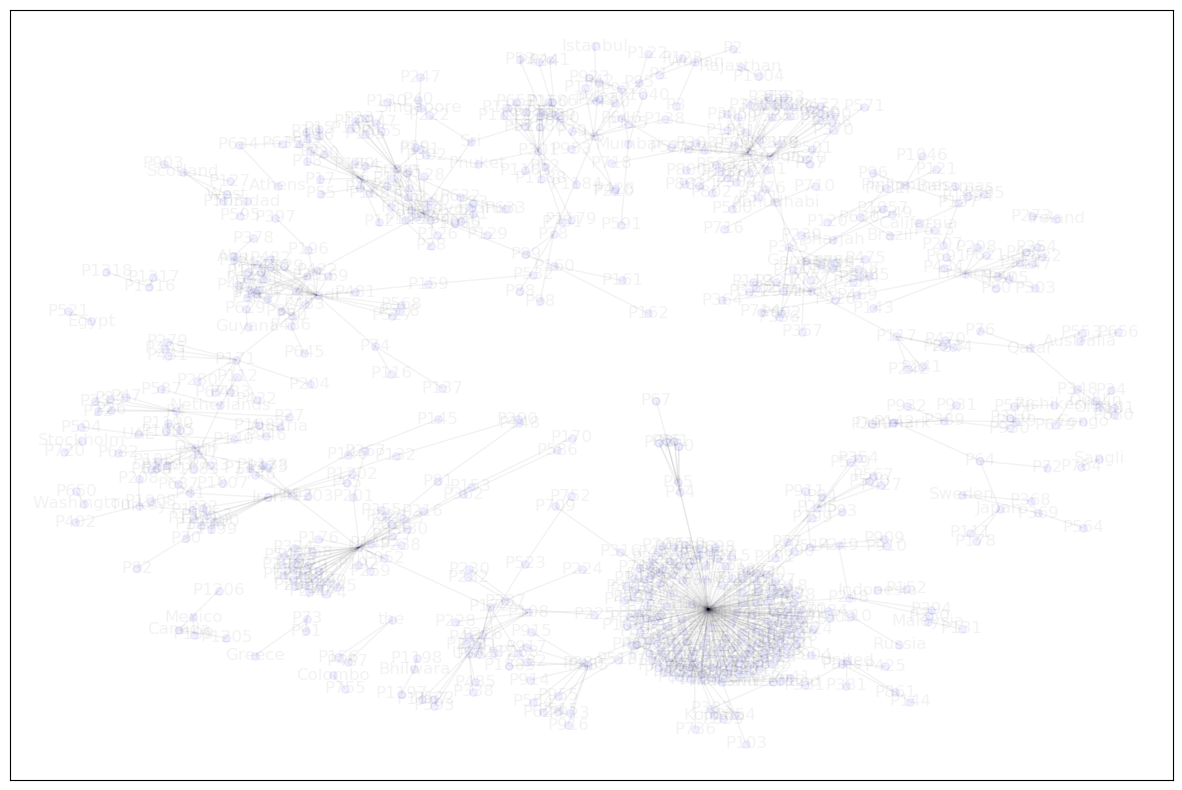

In [15]:
pos = nx.spring_layout(G_social, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    G_social, 
    pos=pos, 
    node_size=30, 
    edge_color="black", 
    alpha=0.05, 
    with_labels=True,
    node_color='blue'
    )
plt.show()

In [16]:
from networkx.algorithms.community.quality import modularity

from networkx.utils.mapped_queue import MappedQueue

__all__ = [
    "greedy_modularity_communities",
    "naive_greedy_modularity_communities",
    "_naive_greedy_modularity_communities",
]


def greedy_modularity_communities(G, weight=None):
    

    # Count nodes and edges
    N = len(G.nodes())
    m = sum([d.get("weight", 1) for u, v, d in G.edges(data=True)])
    q0 = 1.0 / (2.0 * m)

    # Map node labels to contiguous integers
    label_for_node = {i: v for i, v in enumerate(G.nodes())}
    node_for_label = {label_for_node[i]: i for i in range(N)}

    # Calculate degrees
    k_for_label = G.degree(G.nodes(), weight=weight)
    k = [k_for_label[label_for_node[i]] for i in range(N)]

    # Initialize community and merge lists
    communities = {i: frozenset([i]) for i in range(N)}
    merges = []

    # Initial modularity
    partition = [[label_for_node[x] for x in c] for c in communities.values()]
    q_cnm = modularity(G, partition)

    # Initialize data structures
    # CNM Eq 8-9 (Eq 8 was missing a factor of 2 (from A_ij + A_ji)
    # a[i]: fraction of edges within community i
    # dq_dict[i][j]: dQ for merging community i, j
    # dq_heap[i][n] : (-dq, i, j) for communitiy i nth largest dQ
    # H[n]: (-dq, i, j) for community with nth largest max_j(dQ_ij)
    a = [k[i] * q0 for i in range(N)]
    dq_dict = {
        i: {
            j: 2 * q0 - 2 * k[i] * k[j] * q0 * q0
            for j in [node_for_label[u] for u in G.neighbors(label_for_node[i])]
            if j != i
        }
        for i in range(N)
    }
    dq_heap = [
        MappedQueue([(-dq, i, j) for j, dq in dq_dict[i].items()]) for i in range(N)
    ]
    H = MappedQueue([dq_heap[i].h[0] for i in range(N) if len(dq_heap[i]) > 0])

    # Merge communities until we can't improve modularity
    while len(H) > 1:
        # Find best merge
        # Remove from heap of row maxes
        # Ties will be broken by choosing the pair with lowest min community id
        try:
            dq, i, j = H.pop()
        except IndexError:
            break
        dq = -dq
        # Remove best merge from row i heap
        dq_heap[i].pop()
        # Push new row max onto H
        if len(dq_heap[i]) > 0:
            H.push(dq_heap[i].h[0])
        # If this element was also at the root of row j, we need to remove the
        # duplicate entry from H
        if dq_heap[j].h[0] == (-dq, j, i):
            H.remove((-dq, j, i))
            # Remove best merge from row j heap
            dq_heap[j].remove((-dq, j, i))
            # Push new row max onto H
            if len(dq_heap[j]) > 0:
                H.push(dq_heap[j].h[0])
        else:
            # Duplicate wasn't in H, just remove from row j heap
            dq_heap[j].remove((-dq, j, i))
        # Stop when change is non-positive
        if dq <= 0:
            break

        # Perform merge
        communities[j] = frozenset(communities[i] | communities[j])
        del communities[i]
        merges.append((i, j, dq))
        # New modularity
        q_cnm += dq
        # Get list of communities connected to merged communities
        i_set = set(dq_dict[i].keys())
        j_set = set(dq_dict[j].keys())
        all_set = (i_set | j_set) - {i, j}
        both_set = i_set & j_set
        # Merge i into j and update dQ
        for k in all_set:
            # Calculate new dq value
            if k in both_set:
                dq_jk = dq_dict[j][k] + dq_dict[i][k]
            elif k in j_set:
                dq_jk = dq_dict[j][k] - 2.0 * a[i] * a[k]
            else:
                # k in i_set
                dq_jk = dq_dict[i][k] - 2.0 * a[j] * a[k]
            # Update rows j and k
            for row, col in [(j, k), (k, j)]:
                # Save old value for finding heap index
                if k in j_set:
                    d_old = (-dq_dict[row][col], row, col)
                else:
                    d_old = None
                # Update dict for j,k only (i is removed below)
                dq_dict[row][col] = dq_jk
                # Save old max of per-row heap
                if len(dq_heap[row]) > 0:
                    d_oldmax = dq_heap[row].h[0]
                else:
                    d_oldmax = None
                # Add/update heaps
                d = (-dq_jk, row, col)
                if d_old is None:
                    # We're creating a new nonzero element, add to heap
                    dq_heap[row].push(d)
                else:
                    # Update existing element in per-row heap
                    dq_heap[row].update(d_old, d)
                # Update heap of row maxes if necessary
                if d_oldmax is None:
                    # No entries previously in this row, push new max
                    H.push(d)
                else:
                    # We've updated an entry in this row, has the max changed?
                    if dq_heap[row].h[0] != d_oldmax:
                        H.update(d_oldmax, dq_heap[row].h[0])

        # Remove row/col i from matrix
        i_neighbors = dq_dict[i].keys()
        for k in i_neighbors:
            # Remove from dict
            dq_old = dq_dict[k][i]
            del dq_dict[k][i]
            # Remove from heaps if we haven't already
            if k != j:
                # Remove both row and column
                for row, col in [(k, i), (i, k)]:
                    # Check if replaced dq is row max
                    d_old = (-dq_old, row, col)
                    if dq_heap[row].h[0] == d_old:
                        # Update per-row heap and heap of row maxes
                        dq_heap[row].remove(d_old)
                        H.remove(d_old)
                        # Update row max
                        if len(dq_heap[row]) > 0:
                            H.push(dq_heap[row].h[0])
                    else:
                        # Only update per-row heap
                        dq_heap[row].remove(d_old)

        del dq_dict[i]
        # Mark row i as deleted, but keep placeholder
        dq_heap[i] = MappedQueue()
        # Merge i into j and update a
        a[j] += a[i]
        a[i] = 0

    communities = [
        frozenset([label_for_node[i] for i in c]) for c in communities.values()
    ]
    return sorted(communities, key=len, reverse=True)

In [17]:
result=greedy_modularity_communities(G_social)
len(result)

78

In [18]:
result=tuple(sorted(x) for x in result)
print(result)

(['Dubai', 'P104', 'P105', 'P1056', 'P1058', 'P1059', 'P1060', 'P1061', 'P1062', 'P1063', 'P1064', 'P1065', 'P1066', 'P1067', 'P1068', 'P1069', 'P1070', 'P1073', 'P1075', 'P1084', 'P124', 'P125', 'P136', 'P158', 'P174', 'P183', 'P187', 'P191', 'P240', 'P246', 'P257', 'P299', 'P300', 'P313', 'P314', 'P316', 'P317', 'P318', 'P319', 'P320', 'P325', 'P333', 'P334', 'P336', 'P363', 'P372', 'P373', 'P374', 'P375', 'P377', 'P379', 'P386', 'P387', 'P396', 'P401', 'P418', 'P419', 'P443', 'P444', 'P445', 'P446', 'P447', 'P448', 'P449', 'P450', 'P451', 'P452', 'P453', 'P454', 'P455', 'P456', 'P457', 'P458', 'P459', 'P460', 'P461', 'P462', 'P463', 'P464', 'P465', 'P466', 'P468', 'P471', 'P476', 'P484', 'P5', 'P512', 'P513', 'P516', 'P517', 'P547', 'P550', 'P551', 'P552', 'P601', 'P616', 'P617', 'P619', 'P620', 'P63', 'P652', 'P68', 'P69', 'P695', 'P698', 'P699', 'P70', 'P700', 'P701', 'P702', 'P703', 'P704', 'P705', 'P706', 'P707', 'P708', 'P709', 'P711', 'P712', 'P739', 'P75', 'P760', 'P805', 'P8

In [20]:
nxcom.modularity(G_social,nxcom.greedy_modularity_communities(G_social))

0.9004729122431222

In [21]:
nxcom.coverage(G_social,nxcom.greedy_modularity_communities(G_social))

0.9859154929577465

In [22]:
nxcom.performance(G_social,nxcom.greedy_modularity_communities(G_social))

0.9334297941715916

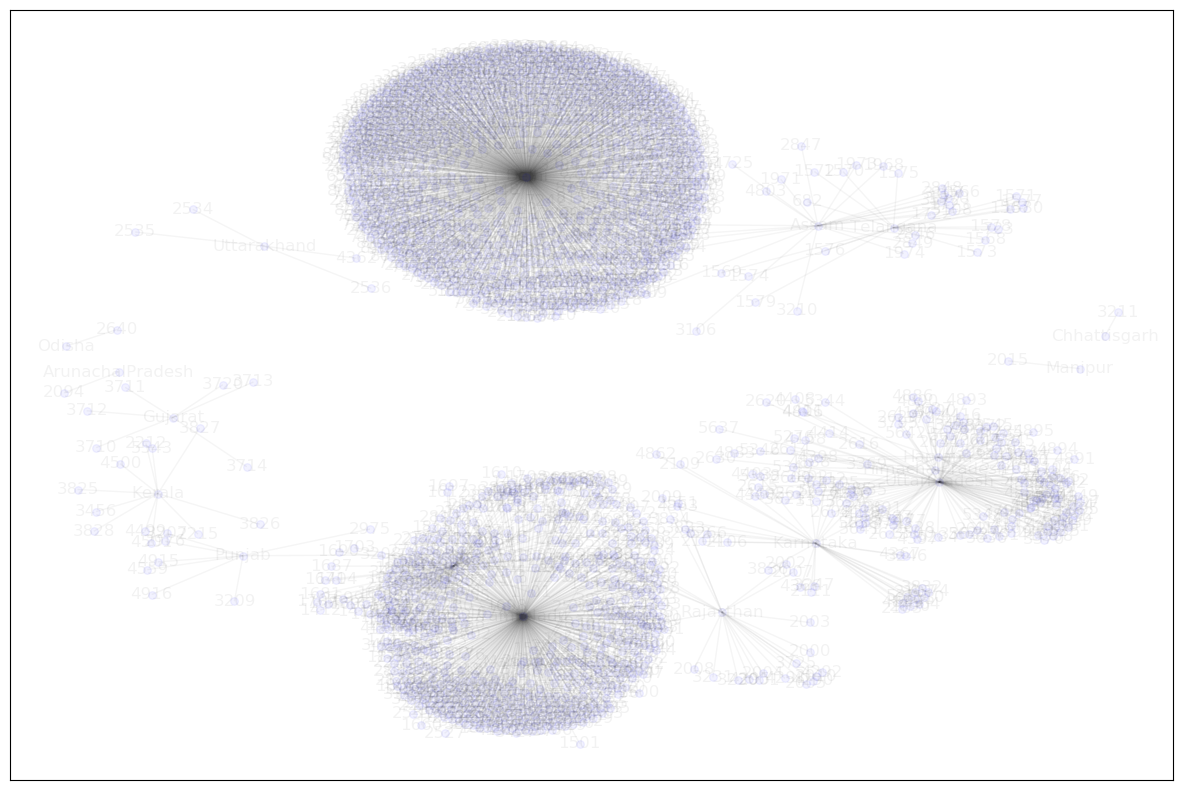

In [24]:
pos = nx.spring_layout(G_social1, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    G_social1, 
    pos=pos, 
    node_size=30, 
    edge_color="#444444", 
    alpha=0.05, 
    with_labels=True,
    node_color='blue'
    )
plt.show()

In [25]:
centrality =nx.algorithms.centrality.load_centrality(G_social)


In [26]:
centrality

{'P6': 0.0020600858369098714,
 'P7': 0.0,
 'P8': 0.0,
 'P9': 0.0,
 'P10': 0.0,
 'P11': 0.0,
 'P12': 0.0,
 'P13': 0.0,
 'P14': 0.0,
 'P15': 0.0,
 'P16': 0.0,
 'P17': 0.0,
 'P18': 0.0,
 'P19': 0.0,
 'P20': 0.0,
 'P21': 0.0,
 'P4': 0.00011444921316165952,
 'P22': 0.0,
 'P23': 0.0,
 'P24': 0.0,
 'P25': 0.0,
 'P26': 0.0,
 'P27': 0.0,
 'P28': 0.0,
 'P35': 0.0008733564956740922,
 'P36': 1.3624906328768987e-06,
 'P37': 1.3624906328768987e-06,
 'P38': 0.0,
 'P39': 0.0,
 'P29': 0.0001594114040465972,
 'P40': 0.0,
 'P47': 0.0,
 'P51': 0.0001594114040465972,
 'P52': 0.0,
 'P53': 0.0,
 'P43': 0.0003147353361945637,
 'P54': 0.0,
 'P55': 0.0,
 'P64': 2.861230329041488e-05,
 'P72': 0.0,
 'P30': 6.539955037809115e-05,
 'P82': 0.0,
 'P41': 6.539955037809115e-05,
 'P84': 0.0,
 'P78': 0.00023298589822194973,
 'P88': 0.0,
 'P89': 0.0,
 'P73': 4.087471898630697e-06,
 'P91': 0.0,
 'P77': 0.0015573267933782955,
 'P93': 0.0,
 'P94': 0.0,
 'P98': 0.0,
 'P74': 0.0002738606172082567,
 'P116': 0.0,
 'P95': 0.00015

In [28]:
result2=greedy_modularity_communities(G_social1)
len(result2)


20

In [29]:
result2=tuple(sorted(x) for x in result2)
print(result2)

(['1000', '1001', '1002', '1003', '1105', '1106', '1107', '1108', '1109', '1110', '1111', '1112', '1113', '1114', '1115', '1116', '1117', '1118', '1119', '1120', '1121', '1122', '1123', '1124', '1125', '1126', '1127', '128', '1282', '1283', '1284', '1285', '1286', '1287', '1288', '1289', '129', '1290', '1291', '1292', '1293', '1294', '1295', '1296', '1297', '1298', '1299', '130', '1300', '1301', '1302', '1303', '1304', '1305', '1306', '1586', '1587', '1588', '1589', '1590', '1591', '1592', '1593', '1594', '1595', '1596', '1597', '1598', '1599', '1600', '1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1658', '171', '1739', '1740', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '197', '198', '199', '204', '205', '206', '2114', '2115', '2116', '2117', '2118', '2119', '2120', '2121', '2122', 

In [33]:
nxcom.modularity(G_social1,greedy_modularity_communities(G_social1))

0.6043277938332905

In [34]:
nxcom.coverage(G_social1,greedy_modularity_communities(G_social1))

1.0

In [35]:
nxcom.performance(G_social1,greedy_modularity_communities(G_social1))

0.6125767953988726